In [1]:
import tensorflow as tf

mnist = tf.keras.datasets.mnist

(X_train, y_train), (X_test, y_test) = mnist.load_data()

X_train.shape, y_train.shape, X_test.shape, y_test.shape


from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential, Model


img_A_inp = Input((28, 28), name='img_A_inp')
img_B_inp = Input((28, 28), name='img_B_inp')

In [2]:

from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.initializers import he_uniform

def get_mlp_block(units):
    return Sequential([Dense(units, activation='relu'),
                       BatchNormalization()])

DEPTH = 64
mlp = Sequential([Flatten(),
                  get_mlp_block(DEPTH),
                  get_mlp_block(DEPTH*2),
                  get_mlp_block(DEPTH*4),
                  get_mlp_block(DEPTH*8),
                  Dense(64, activation='relu')])

feature_vector_A = mlp(img_A_inp)
feature_vector_B = mlp(img_B_inp)

concat = Concatenate()([feature_vector_A, feature_vector_B])

dense = Dense(64, activation='relu')(concat)
#dense2= Dense(128,activation='relu')(dense)
output = Dense(1, activation='sigmoid')(dense)

model = Model(inputs=[img_A_inp, img_B_inp], outputs=output)

model.summary()

# Get the number of layers in the model
num_layers = len(model.layers)

print("Number of layers in the CNN:", num_layers)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 img_A_inp (InputLayer)         [(None, 28, 28)]     0           []                               
                                                                                                  
 img_B_inp (InputLayer)         [(None, 28, 28)]     0           []                               
                                                                                                  
 sequential_4 (Sequential)      (None, 64)           259840      ['img_A_inp[0][0]',              
                                                                  'img_B_inp[0][0]']              
                                                                                                  
 concatenate (Concatenate)      (None, 128)          0           ['sequential_4[0][0]',       

In [3]:
import numpy as np

random_indices = np.random.choice(X_train.shape[0], 100, replace=False)

X_train_sample, y_train_sample = X_train[random_indices], y_train[random_indices]

X_train_sample.shape, y_train_sample.shape

len(X_train_sample) ** 2

import itertools

def make_paired_dataset(X, y):
  X_pairs, y_pairs = [], []

  tuples = [(x1, y1) for x1, y1 in zip(X, y)]
  
  for t in itertools.product(tuples, tuples):
    pair_A, pair_B = t
    img_A, label_A = t[0]
    img_B, label_B = t[1]

    new_label = int(label_A == label_B)

    X_pairs.append([img_A, img_B])
    y_pairs.append(new_label)
  
  X_pairs = np.array(X_pairs)
  y_pairs = np.array(y_pairs)

  return X_pairs, y_pairs

In [4]:
make_paired_dataset(X_train_sample, y_train_sample)

X_train_pairs, y_train_pairs = make_paired_dataset(X_train_sample, y_train_sample)

X_train_pairs.shape, y_train_pairs.shape

random_indices = np.random.choice(X_test.shape[0], 50, replace=False)

X_test_sample, y_test_sample = X_test[random_indices], y_test[random_indices]

X_test_sample.shape, y_test_sample.shape


X_test_pairs, y_test_pairs = make_paired_dataset(X_test_sample, y_test_sample)

X_test_pairs.shape, y_test_pairs.shape

model.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              metrics=['accuracy'])

In [5]:
from tensorflow.keras.callbacks import EarlyStopping

es = EarlyStopping(patience=3)

model.fit(x=[X_train_pairs[:, 0, :, :], X_train_pairs[:, 1, :, :]],
          y=y_train_pairs,
          validation_data=([X_test_pairs[:, 0, :, :], 
                            X_test_pairs[:, 1, :, :]],
                           y_test_pairs),
          epochs=10,
          batch_size=1024,
          callbacks=[es])

img_A, img_B = X_test[0], X_test[17]
label_A, label_B = y_test[0], y_test[17]

label_A, label_B

Epoch 1/10
10/10 [==============================] - 2s 56ms/step - loss: 0.7924 - accuracy: 0.4857 - val_loss: 0.9410 - val_accuracy: 0.2428
Epoch 2/10
10/10 [==============================] - 0s 37ms/step - loss: 0.4548 - accuracy: 0.8551 - val_loss: 0.7421 - val_accuracy: 0.4596
Epoch 3/10
10/10 [==============================] - 0s 38ms/step - loss: 0.3693 - accuracy: 0.8898 - val_loss: 0.6777 - val_accuracy: 0.5832
Epoch 4/10
10/10 [==============================] - 0s 38ms/step - loss: 0.3439 - accuracy: 0.8905 - val_loss: 0.6519 - val_accuracy: 0.6488
Epoch 5/10
10/10 [==============================] - 0s 38ms/step - loss: 0.3335 - accuracy: 0.8908 - val_loss: 0.6333 - val_accuracy: 0.6940
Epoch 6/10
10/10 [==============================] - 0s 38ms/step - loss: 0.3264 - accuracy: 0.8912 - val_loss: 0.6184 - val_accuracy: 0.7124
Epoch 7/10
10/10 [==============================] - 1s 75ms/step - loss: 0.3200 - accuracy: 0.8922 - val_loss: 0.5983 - val_accuracy: 0.7376
Epoch 8/10
10

(7, 7)

False

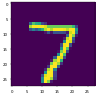

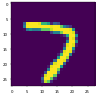

In [6]:
import matplotlib.pyplot as plt

plt.figure(dpi=28)
plt.imshow(img_A)


plt.figure(dpi=28)
plt.imshow(img_B)


model.predict([img_A.reshape((1, 28, 28)), 
               img_B.reshape((1, 28, 28))]).flatten()[0] > 0.5